<a href="https://colab.research.google.com/github/mfrdixon/ML_Finance_Codes/blob/master/G_learning_wealth_management_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ML_in_Finance-G-learning-wealth-management
# Author: Igor Halperin
# Version: 1.0 (12.8.2019)
# License: MIT
# Email: ighalp@gmail.com
# Notes: tested on Mac OS X with Python 3.6 and PyTorch 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

## G-learning for wealth optimization

Using G-learning with quadratic rewards for optimization of defined contribution retirement plan

In [0]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

import numpy as np
import time

import torch

import torch.optim as optim
# import torch.nn as nn
# from torchviz import make_dot

#To ignore warnings that are annoying.
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.__version__

'1.3.1'

In [0]:
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
ar1 = np.ones(2)
ar2 = 2*np.ones(3)

ar3 = np.outer(ar1, ar2)
ar3.shape

(2, 3)

In [0]:
# some examples of PyTorch operations
t1 = torch.zeros(3,2,3,dtype=torch.float64)
t2 = torch.ones(2,2,dtype=torch.float64)
t3 = 2 * t2

t4 = t3.mm(t2)
print(t4)

exp_ret = torch.from_numpy(np.array([[2,3],[3,1]]))
t2 = exp_ret[-1,:] + torch.ones(2,dtype=torch.float64)
print(t2)
t2T = t2.unsqueeze(1) #  t2.transpose
print(t2T)
print(torch.ger(t2,t2))


tensor([[4., 4.],
        [4., 4.]], dtype=torch.float64)
tensor([4., 2.], dtype=torch.float64)
tensor([[4.],
        [2.]], dtype=torch.float64)
tensor([[16.,  8.],
        [ 8.,  4.]], dtype=torch.float64)


In [0]:
torch.max(torch.tensor(0.1), torch.tensor(0.3))

tensor(0.3000)

In [0]:
test_t = torch.zeros(2,3,2,requires_grad=True,dtype=torch.float64)
test_t

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]], dtype=torch.float64, requires_grad=True)

In [0]:
class G_learning_portfolio_opt:
    
    def __init__(self, 
                 num_steps,
                 lambd, 
                 Omega_mat, # of shape (num_risky_assets + 1)x(num_risky_assets + 1) 
                 eta,    
                 rho,
                 benchmark_portf,
                 beta,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 exp_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky assets
                 init_x_vals, # array of initial asset position values (num_risky_assets + 1)
                 use_for_WM = True): # use for wealth management tasks

                
        self.num_steps = num_steps
        
        self.lambd = torch.tensor(lambd, requires_grad=True, dtype=torch.float64)
        self.Omega_mat = torch.tensor(Omega_mat,requires_grad=True, dtype=torch.float64)
        self.beta = torch.tensor(beta, requires_grad=True, dtype=torch.float64)
        self.eta = torch.tensor(eta, requires_grad=True, dtype=torch.float64)
        self.rho = torch.tensor(rho, requires_grad=True, dtype=torch.float64)
        
        self.gamma = gamma
        self.use_for_WM = use_for_WM
        
        self.num_risky_assets = num_risky_assets
        self.r_f = riskfree_rate
        
        self.num_assets = num_risky_assets + 1 # exp_returns.shape[1]
        
        assert exp_returns.shape[0] == self.num_steps
        assert Sigma_r.shape[0] == Sigma_r.shape[1]
        assert Sigma_r.shape[0] == num_risky_assets # self.num_assets
        
        self.Sigma_r_np = Sigma_r # array of shape num_stocks x num_stocks
        
        # arrays of returns for all assets including the risk-free asset
        # array of shape num_steps x (num_stocks + 1) 
        self.exp_returns_np = np.hstack((self.r_f * np.ones(self.num_steps).reshape((-1,1)), exp_returns))
                                      
        # make block-matrix Sigma_r_tilde with Sigma_r_tilde[0,0] = 0, and equity correlation matrix inside
        self.Sigma_r_tilde_np = np.zeros((self.num_assets, self.num_assets))
        self.Sigma_r_tilde_np[1:,1:] = self.Sigma_r_np
            
        # make Torch tensors  
        self.exp_returns = torch.tensor(self.exp_returns_np,requires_grad=False, dtype=torch.float64)
        self.Sigma_r = torch.tensor(Sigma_r,requires_grad=False, dtype=torch.float64)
        self.Sigma_r_tilde = torch.tensor(self.Sigma_r_tilde_np,requires_grad=False, dtype=torch.float64)
        
        self.benchmark_portf = torch.tensor(benchmark_portf, requires_grad=False, dtype=torch.float64)
        
        # asset holding values for all times. Initialize with initial values, 
        # values for the future times will be expected values 
        self.x_vals_np = np.zeros((self.num_steps, self.num_assets))
        self.x_vals_np[0,:] = init_x_vals 
        
        # Torch tensor
        self.x_vals = torch.tensor(self.x_vals_np)
                
        # allocate memory for coefficients of R-, F- and G-functions        
        self.F_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64)
        self.F_x = torch.zeros(self.num_steps, self.num_assets, dtype=torch.float64)
        self.F_0 = torch.zeros(self.num_steps,dtype=torch.float64)
        
        self.Q_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64)
        self.Q_uu = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64)
        self.Q_ux = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64)
        self.Q_x = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64)
        self.Q_u = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64)
        self.Q_0 = torch.zeros(self.num_steps,dtype=torch.float64)
        
        self.R_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64)
        self.R_uu = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64)
        self.R_ux = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64)
        self.R_x = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64)
        self.R_u = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64)
        self.R_0 = torch.zeros(self.num_steps,dtype=torch.float64)

        
        
        # initialize time-dependent parameters of prior policy 
        self.u_bar_prior = torch.zeros(self.num_steps,self.num_assets,requires_grad=True,
                                       dtype=torch.float64)
        self.v_bar_prior =  torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=True,
                                        dtype=torch.float64)
        self.Sigma_prior =  torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=True,
                                        dtype=torch.float64)
        self.Sigma_prior_inv = torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=True,
                                        dtype=torch.float64)
        
        # make each time elements of v_bar_prior and Sigma_prior proportional to the unit matrix
        for t in range(self.num_steps):
            self.v_bar_prior[t,:,:] = 0.1 * torch.eye(self.num_assets)
            self.Sigma_prior[t,:,:] = 0.1 * torch.eye(self.num_assets)
            self.Sigma_prior_inv[t,:,:] = 10.0 * torch.eye(self.num_assets) # np.linalg.inv(self.Sigma_prior[t,:,:])
        
        # the list of adjustable model parameters:
        self.model_params = [self.lambd, self.beta, self.Omega_mat, self.eta]  
#                              self.exp_returns, self.Sigma_r_tilde,self.Sigma_prior_inv, self.u_bar_prior]
        
        
        # expected cash installment for all steps
        self.expected_c_t = torch.zeros(self.num_steps,dtype=torch.float64)
        
        # realized values of the target portfolio
#         self.realized_target_portf = torch.zeros(self.num_steps,dtype=torch.float64)
        self.realized_target_portf = np.zeros(self.num_steps,dtype=np.float64)
        
        # expected portfolio values for all times
        self.expected_portf_val = torch.zeros(self.num_steps,dtype=torch.float64)
        
        # the first value is the sum of initial position values
        self.expected_portf_val[0] = self.x_vals[0,:].sum()
    
    def reward_fun(self, t, x_vals, u_vals, exp_rets, lambd, Sigma_hat):
        """
        The reward function 
        """
        x_plus = x_vals + u_vals
        
        p_hat = self.rho * self.benchmark_portf[t] + (1-self.rho)*self.eta*x_vals.sum()
        
        aux_1 = - self.lambd * p_hat**2         
        aux_2 = - u_vals.sum()   
        aux_3 = 2*self.lambd * p_hat * x_plus.dot(torch.ones(num_assets) + exp_rets)
        aux_4 = - self.lambd * x_plus.mm(Sigma_hat.mv(x_plus))
        aux_5 = - u_vals.mm(self.Omega_mat.mv(u_vals))
        
        return aux_1 + aux_2 + aux_3 + aux_4 + aux_5  
    
    def compute_reward_fun(self):
        """
        Compute coefficients R_xx, R_ux, etc. for all steps
        """
        for t in range(0, self.num_steps):
            
            one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
            benchmark_portf = self.benchmark_portf[t]
            Sigma_hat = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
            
            one_plus_exp_ret_by_one = torch.ger(one_plus_exp_ret,torch.ones(self.num_assets,dtype=torch.float64))
            one_plus_exp_ret_by_one_T = one_plus_exp_ret_by_one.t()     
            one_one_T_mat = torch.ones(self.num_assets,self.num_assets)
            
            self.R_xx[t,:,:] = (-self.lambd*(self.eta**2)*(self.rho**2)*one_one_T_mat
                                 + 2*self.lambd*self.eta*self.rho*one_plus_exp_ret_by_one
                                 - self.lambd*Sigma_hat)
            
            self.R_ux[t,:,:] = (2*self.lambd*self.eta*self.rho*one_plus_exp_ret_by_one
                                 - 2*self.lambd*Sigma_hat)
            
            self.R_uu[t,:,:] = - self.lambd * Sigma_hat - self.Omega_mat
            
            self.R_x[t,:] =  (-2*self.lambd*self.eta*self.rho*(1-self.rho)*benchmark_portf*
                                 torch.ones(self.num_assets,dtype=torch.float64)
                                 + 2*self.lambd*(1-self.rho)*benchmark_portf * one_plus_exp_ret)
            
            self.R_u[t,:] = (2*self.lambd*(1-self.rho)*benchmark_portf * one_plus_exp_ret
                             - torch.ones(self.num_assets,dtype=torch.float64))
            
            self.R_0[t] = - self.lambd*((1-self.rho)**2) * (benchmark_portf**2)
                
         
    def project_cash_injections(self):
        """
        Compute the expected values of future asset positions, and the expected cash injection for future steps,
        as well as realized values of the target portfolio
        """
           
        # this assumes that the policy is trained
        for t in range(1, self.num_steps):  # the initial value is fixed 
            
            # increment the previous x_t
            
            delta_x_t = self.u_bar_prior[t,:] + self.v_bar_prior[t,:,:].mv(self.x_vals[t-1,:])
            self.x_vals[t,:] = self.x_vals[t-1,:] + delta_x_t
            
            # grow using the expected return
            self.x_vals[t,:] = (torch.ones(self.num_assets)+ self.exp_returns[t,:])*self.x_vals[t,:]
            
            # compute c_t
            self.expected_c_t[t] = delta_x_t.sum().data # detach().numpy()
            
            # expected portfolio value for this step
            self.expected_portf_val[t] = self.x_vals[t,:].sum().data # .detach().numpy()
    
#             self.realized_target_portf[t] = (self.x_vals[t,:].sum().data) * (self.eta.detach().numpy())[0]
            
                                                                                      
    def set_terminal_conditions(self):
        """
        set the terminal condition for the F-function
        """
        
        # the auxiliary quantity to perform matrix calculations
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[-1,:]
        
        
        # compute the reward function for all steps (only the last step is needed for this functions, while 
        # values for other time steps will be used in other functions)
        self.compute_reward_fun()
        
        if self.use_for_WM:

            # Note: Pinv in PyTorch may be inaccurate, 
            # see https://discuss.pytorch.org/t/torch-pinverse-seems-to-be-inaccurate/33616
            Sigma_hat = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
            Sigma_hat_inv = torch.pinverse(Sigma_hat)
            Sigma_tilde = Sigma_hat + (1/self.lambd)*self.Omega_mat
            Sigma_tilde_inv = torch.pinverse(Sigma_tilde)
            
            Sigma_hat_sigma_tilde = Sigma_hat.mm(Sigma_tilde)
            Sigma_tilde_inv_sig_hat = Sigma_tilde_inv.mm(Sigma_hat)
            Sigma_tilde_sigma_hat = Sigma_tilde.mm(Sigma_hat)
            
            Sigma_hat_Sigma_tilde_inv = Sigma_hat.mm(Sigma_tilde_inv)
            Sigma_3_plus_omega = self.lambd*Sigma_tilde_inv.mm(Sigma_hat_Sigma_tilde_inv) + self.Omega_mat    
                 
            # matrix Phi
#             Phi_m = (self.eta*torch.ger(one_plus_exp_ret,torch.ones(self.num_assets,dtype=torch.float64)) 
#                      - Sigma_tilde_inv)
            
            one_plus_exp_ret_by_one = torch.ger(one_plus_exp_ret,torch.ones(self.num_assets,dtype=torch.float64))
            one_plus_exp_ret_by_one_T = one_plus_exp_ret_by_one.t()     
            one_one_T_mat = torch.ones(self.num_assets,self.num_assets)
            
            Sigma_tilde_inv_t_R_ux = Sigma_tilde_inv.t().mm(self.R_ux[-1,:,:])
            Sigma_tilde_inv_t_R_uu = Sigma_tilde_inv.t().mm(self.R_uu[-1,:,:])
            Sigma_tilde_inv_t_R_u = Sigma_tilde_inv.t().mv(self.R_u[-1,:])
            
            Sigma_tilde_inv_R_u = Sigma_tilde_inv.mv(self.R_u[-1,:])
            Sigma_tilde_inv_R_ux = Sigma_tilde_inv.mm(self.R_ux[-1,:,:])
            Sigma_tilde_inv_t_R_uu = Sigma_tilde_inv.mm(self.R_uu[-1,:,:])
            
            # though the action at the last step is deterministic, we can feed 
            # parameters of the prior with these values                     
              
            self.u_bar_prior[-1,:]   = (1/(2 * self.lambd))* Sigma_tilde_inv.mv(self.R_u[t,:])
            self.v_bar_prior[-1,:,:] = (1/(2 * self.lambd))* Sigma_tilde_inv.mm(self.R_ux[t,:,:])    
                
            # First compute the coefficients of the reward function at the last step

            
            # the coefficients of F-function for the last step
            
            # F_xx                 
            self.F_xx[-1,:,:] = (self.R_xx[-1,:,:]
                                 + (1/(2*self.lambd))* self.R_ux[-1,:,:].t().mm(Sigma_tilde_inv_t_R_ux)
                                 + (1/(4*self.lambd**2))* self.R_ux[-1,:,:].t().mm(
                                      Sigma_tilde_inv_t_R_uu.mm(Sigma_tilde_inv.mm(self.R_ux[-1,:,:])))
                                )
            
            # F_x                    
            self.F_x[-1,:] = (self.R_x[-1,:]
                                 + (1/(self.lambd))* self.R_ux[-1,:,:].t().mv(Sigma_tilde_inv_t_R_u)
                                 + (1/(2*self.lambd**2))* self.R_ux[-1,:,:].t().mv(
                                      Sigma_tilde_inv_t_R_uu.mv(Sigma_tilde_inv_R_u))
                            )
            
            
        
            # F_0   
            self.F_0[-1] = (self.R_0[-1] 
                            +  (1/(2*self.lambd))* self.R_u[-1,:].dot(Sigma_tilde_inv_R_u)
                            + (1/(4*self.lambd**2))* self.R_u[-1,:].dot(
                                Sigma_tilde_inv_t_R_uu.mv(Sigma_tilde_inv_R_u))
                           )
            
                
    def G_learning(self, err_tol, max_iter):
        """
        find the optimal policy for the time dependent policy
        
        """
        
        print('Doing G-learning, it may take a few seconds...')
        
        # set terminal conditions
        self.set_terminal_conditions()
        
        # allocate iteration numbers for all steps
        self.iter_counts = np.zeros(self.num_steps)
        
        # iterate over time steps backward
        for t in range(self.num_steps-2,-1,-1):
            self.step_G_learning(t, err_tol, max_iter)
            
    def step_G_learning(self, t, err_tol, max_iter):
        """
        Perform one step of backward iteration for G-learning self-consistent equations
        This should start from step t = num_steps - 2 (i.e. from a step that is before the last one)
        """
            
        # local variables
        F_xx_tp1 = self.F_xx[t+1,:,:]
        F_x_tp1 = self.F_x[t+1,:]
        F_0_tp1 = self.F_0[t+1]
            
        # make matrix Sigma_hat_t        
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
        Sigma_hat_t = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
        
        # matrix A_t = diag(1 + r_bar_t)
        A_t = torch.diag(torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:])
                    
        # update parameters of Q_function using next-step F-function values
        self.update_Q_params(t, A_t,Sigma_hat_t)
             
        # iterate between policy evaluation and policy improvement  
        while self.iter_counts[t] < max_iter:
                
            curr_u_bar_prior = self.u_bar_prior[t,:].clone()  
            curr_v_bar_prior = self.v_bar_prior[t,:,:].clone()     
                
            # compute parameters of F-function for this step from parameters of Q-function
            self.update_F_params(t) 
              
            # Policy iteration step: update parameters of the prior policy distribution
            # with given Q- and F-function parameters
            self.update_policy_params(t)    
            
            # difference between the current value of u_bar_prior and the previous one
            err_u_bar = torch.sum((curr_u_bar_prior - self.u_bar_prior[t,:])**2)
            
            # divide by num_assets in err_v_bar to get both errors on a comparable scale
            err_v_bar = (1/self.num_assets)*torch.sum((curr_v_bar_prior - self.v_bar_prior[t,:,:])**2)
            
            # choose the difference from the previous iteration as the maximum of the two errors
            tol = torch.max(err_u_bar, err_v_bar)  # tol = 0.5*(err_u_bar + err_v_bar)

#             print('err_u_bar, err_v_bar, tol', err_u_bar, err_v_bar, tol)
            
            self.iter_counts[t] += 1
            # Repeat the calculation of Q- and F-values
            if tol <= err_tol:
                break
                
            
    def update_Q_params(self,t, A_t,Sigma_hat_t):
        """
        update the current (time-t) parameters of Q-function from (t+1)-parameters of F-function
        """ 
                
        ones = torch.ones(self.num_assets,dtype=torch.float64)    
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
#         one_plus_exp_ret_1T = torch.ger(one_plus_exp_ret, ones)
    
        self.Q_xx[t,:,:] = (self.R_xx[t,:,:] 
                            + self.gamma*( (A_t.mm(self.F_xx[t+1,:,:])).mm(A_t)  
                                           + self.Sigma_r_tilde * self.F_xx[t+1,:,:] ) )


        self.Q_ux[t,:,:] = (self.R_ux[t,:,:] 
                            + 2 * self.gamma*( (A_t.mm(self.F_xx[t+1,:,:])).mm(A_t)  
                                           + self.Sigma_r_tilde * self.F_xx[t+1,:,:] ) 
                           )
    
        self.Q_uu[t,:,:] = (self.R_uu[t,:,:]  
                            + self.gamma*( (A_t.mm(self.F_xx[t+1,:,:])).mm(A_t)  
                                           + self.Sigma_r_tilde * self.F_xx[t+1,:,:] )
                            - self.Omega_mat
                           )


        self.Q_x[t,:] = self.R_x[t,:] + self.gamma * A_t.mv(self.F_x[t+1,:]) 
        self.Q_u[t,:] = self.R_u[t,:] + self.gamma * A_t.mv(self.F_x[t+1,:])
        self.Q_0[t]   = self.R_0[t] + self.gamma * self.F_0[t+1]


        
    def update_F_params(self,t):
        """
        update the current (time-t) parameters of F-function from t-parameters of G-function
        This is a policy evaluation step: it uses the current estimations of the mean parameters of the policy
        
        """
        
        # produce auxiliary parameters U_t, W_t, Sigma_tilde_t
        U_t = self.beta * self.Q_ux[t,:,:] + self.Sigma_prior_inv[t,:,:].mm(self.v_bar_prior[t,:,:])
        W_t = self.beta * self.Q_u[t,:] +  self.Sigma_prior_inv[t,:,:].mv(self.u_bar_prior[t,:])
        Sigma_p_bar =  self.Sigma_prior_inv[t,:,:] - 2 * self.beta * self.Q_uu[t,:,:]
        Sigma_p_bar_inv = torch.pinverse(Sigma_p_bar)
        
        # update parameters of F-function
        self.F_xx[t,:,:] = self.Q_xx[t,:,:] + (1/(2*self.beta))*(U_t.t().mm(Sigma_p_bar_inv.mm(U_t))
                                    - self.v_bar_prior[t,:,:].t().mm(
                                        self.Sigma_prior_inv[t,:,:].mm(self.v_bar_prior[t,:,:])))
        
        
        self.F_x[t,:] = self.Q_x[t,:] + (1/self.beta)*(U_t.mv(Sigma_p_bar_inv.mv(W_t))
                                    - self.v_bar_prior[t,:,:].mv(
                                        self.Sigma_prior_inv[t,:,:].mv(self.u_bar_prior[t,:])))
        
        
        self.F_0[t] = self.Q_0[t] + ( (1/(2*self.beta))*(W_t.dot(Sigma_p_bar_inv.mv(W_t))
                                    - self.u_bar_prior[t,:].dot(
                                        self.Sigma_prior_inv[t,:,:].mv(self.u_bar_prior[t,:])))
                                    - (1/(2*self.beta)) * (torch.log(torch.det(self.Sigma_prior[t,:,:]))
                                                       + torch.log(torch.det(Sigma_p_bar))) )
        
    def update_policy_params(self,t):
        """
        update parameters of the Gaussian policy using current coefficients of the F- and G-functions
        """
        
        new_Sigma_prior_inv = self.Sigma_prior_inv[t,:,:] - 2 * self.beta * self.Q_uu[t,:,:]
        Sigma_prior_new = torch.pinverse(new_Sigma_prior_inv)
        
        
        # update parameters using the previous value of Sigma_prior_inv
        self.u_bar_prior[t,:] = Sigma_prior_new.mv(self.Sigma_prior_inv[t,:,:].mv(self.u_bar_prior[t,:])
                                              + self.beta * self.Q_u[t,:])
        
        
        self.v_bar_prior[t,:,:] = Sigma_prior_new.mm(self.Sigma_prior_inv[t,:,:].mm(self.v_bar_prior[t,:,:])
                                              + self.beta * self.Q_ux[t,:,:])
        
        # and then assign the new inverse covariance for the prior for the next iteration
        self.Sigma_prior[t,:,:] = Sigma_prior_new
        self.Sigma_prior_inv[t,:,:] = new_Sigma_prior_inv
        
        # also assign the same values for the previous time step
        if t > 0:
            self.Sigma_prior[t-1,:,:] = self.Sigma_prior[t,:,:]
            self.u_bar_prior[t-1,:] = self.u_bar_prior[t,:]
            self.v_bar_prior[t-1,:,:] = self.v_bar_prior[t,:,:]
            
    def trajs_to_torch_tensors(self,trajs):
        """
        Convert data from a list of lists into Torch tensors
        """
        num_trajs = len(trajs)
        
        self.data_xvals = torch.zeros(num_trajs,self.num_steps,self.num_assets,dtype=torch.float64)
        self.data_uvals = torch.zeros(num_trajs,self.num_steps,self.num_assets,dtype=torch.float64)
            
        for n in range(num_trajs):
            for t in range(self.num_steps):
                self.data_xvals[n,t,:] = torch.tensor(trajs[n][t][0],dtype=torch.float64)
                self.data_uvals[n,t,:] = torch.tensor(trajs[n][t][1],dtype=torch.float64)
                
    def compute_reward_on_traj(self,
                              t,
                              x_t, u_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.R_xx[t,:,:].mv(x_t))
        aux_ux = u_t.dot(self.R_ux[t,:,:].mv(x_t))
        aux_uu = u_t.dot(self.R_uu[t,:,:].mv(u_t))
        aux_x = x_t.dot(self.R_x[t,:])
        aux_u = u_t.dot(self.R_u[t,:])
        aux_0 = self.R_0[t]
        
        return aux_xx + aux_ux + aux_uu + aux_x + aux_u + aux_0
    
    def compute_G_fun_on_traj(self,
                              t,
                              x_t, u_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.Q_xx[t,:,:].mv(x_t))
        aux_ux = u_t.dot(self.Q_ux[t,:,:].mv(x_t))
        aux_uu = u_t.dot(self.Q_uu[t,:,:].mv(u_t))
        aux_x = x_t.dot(self.Q_x[t,:])
        aux_u = u_t.dot(self.Q_u[t,:])
        aux_0 = self.Q_0[t]
        
        return aux_xx + aux_ux + aux_uu + aux_x + aux_u + aux_0
    
    def compute_F_fun_on_traj(self,
                              t,
                              x_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.F_xx[t,:,:].mv(x_t))
        aux_x = x_t.dot(self.F_x[t,:])
        aux_0 = self.F_0[t]
        
        return aux_xx + aux_x + aux_0

                 
    def MaxEntIRL(self,
                  trajs,
                  learning_rate,
                  err_tol, max_iter):
        
        """
        Estimate parameters of the reward function using MaxEnt IRL.
        Inputs:
        
        trajs - a list of trajectories. Each trajectory is a list of state-action pairs, stored as a tuple.
                We assume each trajectory has the same length
        """
        
        # omega is a tunable parameter that determines the cost matrix self.Omega_mat
        omega_init = 1.0
        self.omega = torch.tensor(omega_init, requires_grad=True, dtype=torch.float64)
        
        reward_params =  [self.lambd, self.eta, self.rho, self.omega, self.beta]
        
        self.Omega_mat = self.omega * torch.eye(self.num_assets,dtype=torch.float64)
        
        self.G_learning(err_tol, max_iter)
        
        optimizer = optim.Adam(reward_params, lr=learning_rate)
        
        optimizer.zero_grad()
        
        num_trajs = len(trajs)
        
        # fill in Torch tensors for the trajectory data
        self.trajs_to_torch_tensors(trajs)
           
        self.realized_rewards = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64)
        self.realized_cum_rewards = torch.zeros(num_trajs, dtype=torch.float64)
        
        self.realized_G_fun = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64)
        self.realized_F_fun = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64)
        
        self.realized_G_fun_cum = torch.zeros(num_trajs,dtype=torch.float64)
        self.realized_F_fun_cum = torch.zeros(num_trajs,dtype=torch.float64)
        
        
        num_iter_IRL = 3
        
        for i in range(num_iter_IRL):
            
            print('GIRL iteration = ', i)
       
            self.Omega_mat = self.omega * torch.eye(self.num_assets,dtype=torch.float64)
    
            for n in range(num_trajs):
                for t in range(self.num_steps):
                    
                    
                    # compute rewards obtained at each step for each trajectory
                    # given the model paramaters
        
                    self.realized_rewards[n,t] = self.compute_reward_on_traj(t,
                                                                self.data_xvals[n,t,:],
                                                                self.data_uvals[n,t,:])
                                                                
            
                    # compute the log-likelihood by looping over trajectories
                    self.realized_G_fun[n,t] = self.compute_G_fun_on_traj(t,
                                                                self.data_xvals[n,t,:],
                                                                self.data_uvals[n,t,:])
                
                
                    self.realized_F_fun[n,t] = self.compute_F_fun_on_traj(t,
                                                                self.data_xvals[n,t,:])
                

                self.realized_cum_rewards[n] = self.realized_rewards[n,:].sum()
                self.realized_G_fun_cum[n] = self.realized_G_fun[n,:].sum()
                self.realized_F_fun_cum[n] = self.realized_G_fun[n,:].sum()
            
            # the negative log-likelihood will not include terms ~ Sigma_p as we do not optimize over its value
            loss = - self.beta*(self.realized_G_fun_cum.sum() - self.realized_F_fun_cum.sum())
        
            optimizer.zero_grad()
        
            loss.backward() 
        
            optimizer.step()
        
            print('Iteration = ', i)
            print('Loss = ', loss.detach().numpy())
        
        
        
        
        print('Done optimizing reward parameters')
            
#     def check_convergence(self, new_T0, new_transition, new_emission):
  
#         delta_T0 = torch.max(torch.abs(self.T0 - new_T0)).item() < self.epsilon
#         delta_T = torch.max(torch.abs(self.T - new_transition)).item() < self.epsilon
#         delta_E = torch.max(torch.abs(self.E - new_emission)).item() < self.epsilon

#         return delta_T0 and delta_T and delta_E
    
        



## Simulate portfolio data

### Simulate the market factor as a lognormal with a fixed drift and vol

In [0]:
mu_market = 0.05
vol_market = 0.25
init_market_val = 100.0

r_rf = 0.02  # risk-free rate - the first asset will be cash

num_steps = 10 
dt = 0.25 # quarterly time steps

num_risky_assets = 99 # 100

returns_market = np.zeros(num_steps)
market_vals = np.zeros(num_steps)
market_vals[0] = 100.0  # initial value


        
for t in range(1,num_steps):

        rand_norm = np.random.randn()
        
        # use log-returns of market as 'returns_market'
        returns_market[t] = mu_market * dt + vol_market * np.sqrt(dt) * rand_norm
        
        market_vals[t] = market_vals[t-1] * np.exp((mu_market - 0.5*vol_market**2)*dt + 
                                                         vol_market*np.sqrt(dt)*rand_norm)
        

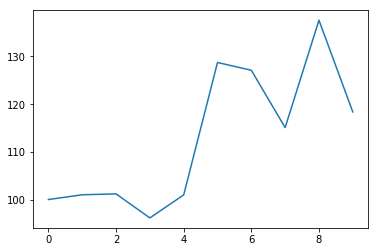

In [0]:
plt.plot(market_vals)

### Simulate market betas and idiosyncratic alphas within pre-defined ranges

In [6]:
beta_min = 0.05
beta_max = 0.85
beta_vals = np.random.uniform(low=beta_min, high=beta_max, size=num_risky_assets)

alpha_min = - 0.05
alpha_max = 0.15
alpha_vals = np.random.uniform(low=alpha_min, high=alpha_max, size=num_risky_assets)

print(beta_vals[0:10])
print(alpha_vals[0:10])

[0.0842848  0.45543819 0.80608157 0.47250252 0.31762463 0.73996484
 0.50011402 0.41113022 0.18095608 0.60954743]
[-0.00338752  0.09271183  0.04032351  0.10420797 -0.01144807  0.09202738
 -0.00620055 -0.04956128  0.12830047  0.09165638]


### Simulate time-dependent expected returns

In [0]:
# time-independent expected returns would be equal to alpha + beta * expected_market_return 
# make them time-dependent (and correlated with actual returns) as alpha + beta * oracle_market_returns
# oracle expected returns pick into the future! 

oracle_coeff = 0.2
mu_vec = mu_market * np.ones(num_steps)
oracle_market_returns = mu_vec * dt + oracle_coeff*(returns_market - mu_vec) 

expected_risky_returns = np.zeros((num_steps, num_risky_assets))

for t in range(num_steps):
    expected_risky_returns[t,:] = alpha_vals * dt + beta_vals * oracle_market_returns[t]

### Initial values of all assets 

In [0]:
val_min = 20.0
val_max = 120.0

init_risky_asset_vals = np.random.uniform(low=val_min, high=val_max, size=num_risky_assets)

### Simulate realized returns and asset prices

In [0]:
# make realized returns and realized asset values by simulating from a one-factor model 
# with time-dependent expected returns

risky_asset_returns = np.zeros((num_steps, num_risky_assets))
risky_asset_vals = np.zeros((num_steps, num_risky_assets))

idiosync_vol =  0.05 # vol_market #  

for t in range(num_steps):
    
    rand_norm = np.random.randn(num_risky_assets)
        
    # asset returns are simulated from a one-factor model
    risky_asset_returns[t,:] = (expected_risky_returns[t,:] + beta_vals * (returns_market[t] - mu_market * dt) 
                         + idiosync_vol * np.sqrt(1 - beta_vals**2) * np.sqrt(dt) * rand_norm)
        
    # asset values
    if t == 0:
        risky_asset_vals[t,:] = init_risky_asset_vals
    else:
        risky_asset_vals[t] = risky_asset_vals[t-1] * (1 + risky_asset_returns[t,:])
   

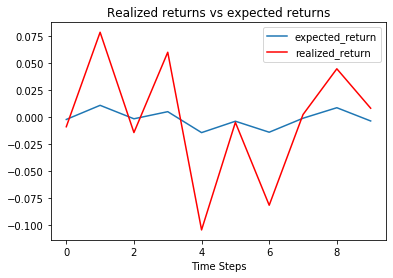

In [11]:
# compare the realized and expected returns
# Note that they appear correlated - this is because we constructed them so!

# pick a random asset to show
asset_idx =  4 # 8 # 6 # 5

plt.plot(expected_risky_returns[:,asset_idx],label='expected_return')
plt.plot(risky_asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Realized returns vs expected returns')
plt.show()


### Compute the empirical correlation matrix using realized returns

In [12]:
cov_mat_r = np.cov(risky_asset_returns.T) 

print(cov_mat_r.shape)

D,v = np.linalg.eigh(cov_mat_r)

eigenvals = D[::-1]  # put them in a descended order

(99, 99)


In [13]:
# eigenvalues: the largest eigenvalue is the market factor 
eigenvals[0:10]

array([6.09696411e-01, 7.49262351e-03, 6.59977609e-03, 5.44053910e-03,
       5.16894228e-03, 4.80217014e-03, 3.89928069e-03, 3.38052740e-03,
       2.63098508e-03, 1.26309957e-16])

### Add a riskless bond as one more asset

In [0]:
num_assets = num_risky_assets + 1

bond_val = 100.0

# add the bond to initial assets
init_asset_vals = np.hstack((np.array([bond_val]),
                            init_risky_asset_vals))

### Make the initial portfolio 

In [0]:
# consider here two choices: equal or equally-weighted 

init_port_choice =  'equal' # 'equally_weighted'  #

init_cash = 1000.0
init_total_asset = np.sum(init_asset_vals)

x_vals_init = np.zeros(num_assets)

if init_port_choice == 'equal': 
    # hold equal amounts of cash in each asset
    amount_per_asset = init_cash/num_assets
    x_vals_init = amount_per_asset * np.ones(num_assets)

elif init_port_choice == 'equally_weighted':
    amount_per_asset = init_cash/init_total_asset
    x_vals_init = amount_per_asset * init_asset_vals
    


### Make the target portfolio

In [16]:
# make a target portfolio term structure by defining it as the initial portfolio growing at some fixed and high rate

target_portfolio = [init_cash]

target_return = 0.15 # 0.20
coeff_target = 1.1 # 1.2 # 1.0

for i in range(1,num_steps):
    target_portfolio.append(target_portfolio[i-1]*np.exp(dt * target_return) )
    
target_portfolio = coeff_target*np.array(target_portfolio)    
print(target_portfolio[0], target_portfolio[-1])

1100.0 1541.5835692311712


### Define model parameters

In [17]:
riskfree_rate = 0.02
fee_bond = 0.05 # 0.01 # 
fee_stock = 0.1 # 0.05 # 20.0 # 0.1 # 1.0 # 100 # 1.0 # 0.5 

all_fees = np.zeros(num_risky_assets + 1)
all_fees[0] = fee_bond
all_fees[1:] = fee_stock
Omega_mat = np.diag(all_fees)


# model parameters

lambd = 0.001 #  0.00065 # 0.0006 # 0.001 # 1.0 # 5.0 # 3.0 # 5.0 # 0.1 # 0.12 # 0.08 # 0.05 # 0.0005
Omega_mat = 15.5 * np.diag(all_fees) # 16.5 * # 100.0 * np.diag(all_fees)
# Omega_mat = 120.0 * np.diag(all_fees)
eta = 1.5 # 1.3 # 1.5 # 1.2

beta = 100.0
gamma = 0.95 

exp_returns = expected_risky_returns

Sigma_r = cov_mat_r

# make the benchmark target portfolio by growing the initial portfolio value at rate eta
# benchmark_portf = [init_cash]

target_return =  0.5 # 0.4 # 0.25 # 0.15 #
# coeff_target = 1.1 # 1.2 # 1.0
benchmark_portf = [ init_cash * np.exp(dt * target_return)]

rho = 0.4 # 0.4 # 0.2 # 0.2 # 0.5

for i in range(1,num_steps):
    benchmark_portf.append(benchmark_portf[i-1]*np.exp(dt * target_return) )
    
# target_portfolio = coeff_target*np.array(target_portfolio)    
print(benchmark_portf[0], benchmark_portf[-1])

1133.1484530668263 3490.3429574618413


### Simulate portfolio data

Produce a list of trajectories, where each trajectory is a list made of state-action pairs

In [19]:
num_sim = 1000
trajs = []

t_0 = time.time()

x_vals = [x_vals_init]
for n in range(num_sim):
    this_traj = []
    x_t = x_vals_init[:]
    for t in range(0,num_steps):
        
        exp_returns = np.hstack([riskfree_rate,expected_risky_returns[t,:]])
        
        Sigma_r_np = Sigma_r # array of shape num_stocks x num_stocks
                                              
        # make block-matrix Sigma_r_tilde with Sigma_r_tilde[0,0] = 0, and equity correlation matrix inside
        Sigma_r_tilde = np.zeros((num_assets, num_assets))
        Sigma_r_tilde[1:,1:] = Sigma_r
        
        one_plus_exp_ret = np.ones(num_assets) + exp_returns
        
        Sigma_hat_t = Sigma_r_tilde + np.outer(one_plus_exp_ret, one_plus_exp_ret)
        Sigma_tilde = Sigma_hat_t + (1/lambd)*Omega_mat
        Sigma_tilde_inv = np.linalg.pinv(Sigma_tilde)
        
        # compute u_t
        
        # first compute R_u, R_ux
        R_u = (- np.ones(num_assets) + 2*lambd*(1-rho)*benchmark_portf[t]*(np.ones(num_assets)+
                                                                         exp_returns))
        
        R_ux = (2*lambd*eta*rho*np.outer(np.ones(num_assets)+exp_returns,
                                       np.ones(num_assets)) - 2*lambd*Sigma_hat_t)
        
        
        u_t = (1/(2*lambd))* Sigma_tilde_inv.dot(R_u + R_ux.dot(x_t))
        
        # randomize the action
        sigma_p = 0.2
        rand_norm_p = np.random.randn(num_assets)
        u_t = u_t *(np.ones(num_assets) + sigma_p*rand_norm_p)
        
        # compute new values of x_t
        x_next = x_t + u_t
    
        # grow this with random return
        
        idiosync_vol =  0.05 # vol_market #      
        rand_norm = np.random.randn(num_risky_assets)
        
        # asset returns are simulated from a one-factor model
        risky_asset_returns = (expected_risky_returns[t,:] + beta_vals * (returns_market[t] - mu_market * dt) 
                         + idiosync_vol * np.sqrt(1 - beta_vals**2) * np.sqrt(dt) * rand_norm)
        
        returns = np.hstack((riskfree_rate,risky_asset_returns))
        
        x_next = (1+returns)*x_next
        
        this_traj.append((x_t, u_t))
        
        # rename
        x_t = x_next
    
    # end the loop over time steps
    trajs.append(this_traj)

print('Done simulating trajectories in %f sec'% (time.time() - t_0))        

Done simulating trajectories in 25.646238 sec


In [0]:
np.save('State_act_trajs.npy', trajs)

In [0]:
trajs2 = np.load('State_act_trajs.npy')

In [0]:
print(len(trajs2[95][-1][0]))  # the number of asset position
print(len(trajs2[95]))  # the number of time steps in each trajectory

100
10


## Train G-learning on simulated data

In [0]:
# create a G-learner
G_learner = G_learning_portfolio_opt(num_steps,
                 lambd, 
                 Omega_mat, 
                 eta,
                 rho,
                 benchmark_portf,
                 beta,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 expected_risky_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky matrix                    
                 x_vals_init, # array of initial values of len (num_stocks+1)
                 use_for_WM = True) # use for wealth management tasks
                 


In [22]:
# Do G-learning

err_tol=1.e-8 # 5.0e-5 
max_iter=500

t_0 = time.time()

G_learner.G_learning(err_tol=err_tol, max_iter=max_iter)

print('Done in %f sec'% (time.time() - t_0))

Doing G-learning, it may take a few seconds...
Done in 1.569658 sec


In [23]:
G_learner.iter_counts

array([24., 23., 22., 21., 20., 19., 19., 21., 35.,  0.])

## Results of G-learning

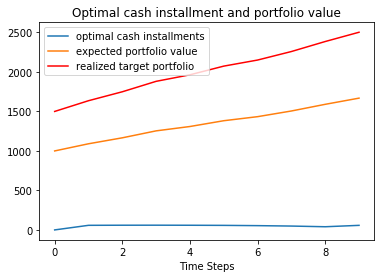

In [24]:
G_learner.project_cash_injections()

eta_ = G_learner.eta.detach().numpy()
realized_target_portf = eta_ * G_learner.expected_portf_val.numpy()

plt.plot(G_learner.expected_c_t, label='optimal cash installments')
plt.plot(G_learner.expected_portf_val, label='expected portfolio value')
plt.plot(realized_target_portf,label='realized target portfolio',color='r')

plt.legend()
# plt.ylim(-1000,2000)
plt.xlabel('Time Steps')
plt.title('Optimal cash installment and portfolio value')
# plt.savefig('G_learning_wealth_unconstrained.png')
plt.show()

In [25]:
G_learner.expected_c_t

tensor([ 0.0000, 58.1777, 59.4622, 59.8229, 59.0535, 57.5410, 54.1232, 48.8190,
        40.1209, 57.8093], dtype=torch.float64)

### GIRL (G-learning IRL)

In [0]:
learning_rate = 0.01
torch.autograd.set_detect_anomaly(True)
G_learner.MaxEntIRL(trajs, learning_rate,err_tol,max_iter)

Doing G-learning, it may take a few seconds...
GIRL iteration =  0


In [0]:
print(G_learner.realized_rewards[1, 0:5])
print(G_learner.realized_rewards[10, 0:5])

tensor([ -70.6741, -120.5512, -191.0832, -316.7193, -481.4396],
       dtype=torch.float64, grad_fn=<SliceBackward>)
tensor([ -70.7036, -121.1960, -193.2990, -322.7138, -488.9079],
       dtype=torch.float64, grad_fn=<SliceBackward>)


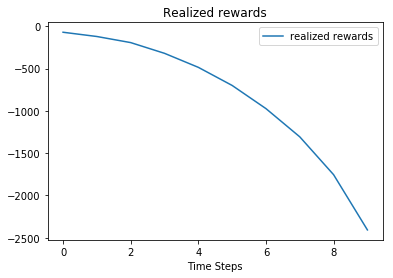

In [0]:
sim_idx =  100 # 4 # 8 # 6 # 5

realized_rewards = G_learner.realized_rewards[sim_idx,:].detach().numpy()
plt.plot(realized_rewards,label='realized rewards')
# plt.plot(risky_asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Realized rewards')
plt.show()



(array([  4.,  26.,  82., 187., 249., 235., 144.,  54.,  14.,   5.]),
 array([-8462.88890375, -8443.93930171, -8424.98969966, -8406.04009762,
        -8387.09049558, -8368.14089353, -8349.19129149, -8330.24168945,
        -8311.2920874 , -8292.34248536, -8273.39288332]),
 <a list of 10 Patch objects>)

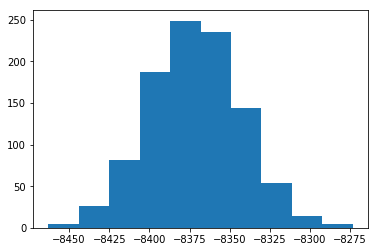

In [0]:
plt.hist(G_learner.realized_cum_rewards.detach().numpy())

In [0]:
# from numpy version (with different parameters):

# array([   0.        , -259.81511723,  -99.29580835,  -34.04944049,
#          -1.25448785,   12.66338554,   31.44010653,   56.64194962,
#         118.01539888,  269.24958773])